# HarvestStat Data Profiling - Mozambique

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32736' # Mozambique
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MZ_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Mozambique',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best',
    'data_usage_policy':'Public'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,  params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
print(df.groupby(['status','collection_status','data_usage_policy']).size().reset_index(name='count'))
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	| nan	| 0	|
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 154	| nan	| 0	|
| 2016	 | MZ2016A1 | 11	| MZ2016A2	| 157	| nan	| 0	|
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 160	| nan	| 0	|
----------------------------------------------- #
                  status collection_status data_usage_policy  count
0              Collected         Published            Public   9369
1  Missing Historic Data         Published            Public    417
2          Not Available         Published            Public   1880
3          Not Collected         Published            Public   7198


In [3]:
# Manual Pre-processing before Sweeping --------- #
# Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Remove the 2005 Sweet Potatoes data (unreliable data, Donghoon)
rdx = df[(df['season_year']=='Main harvest 2005') & (df['product']=='Sweet Potatoes')]
df = df.drop(rdx.index)
# Change the season name
df['season_name'] = df['season_name'].replace({'Main harvest': 'Main'})
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MZ_Admin1_1990 ,MZ_Admin1_2013, MZ_Admin1_2016, MZ_Admin1_2021], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 18,820
Removed 9,482 "Missing Value" points
0/4,705 "Area Harvested" points are retained.
3,439/4,705 "Area Planted" points are retained.
3,291/4,705 "Quantity Produced" points are retained.
2,608/4,705 "Yield" points are retained.
Current data points: 9,338

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2022
57 grain types are found: Bambara groundnut, Banana (unspecified), Beans (Lima), Beans (Rosecoco), Beans (mixed), Beet, Cabbage (Unspecified), Capsicum frutescens,unspecified, Carrots, Cashew (unshelled), Cassava, Chili pepper (Unspecified), Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Garlic (fresh), Ginger, Green bean (fresh), Groundnuts (In Shell), Groundnuts (In Shell, Large), Groundnuts (In Shell, Small), Jute, Kale, Lettuce (Unspecified), Macadamia (unspecified), Maize Grain (White), Millet, Mung bean (unspecifi


- Mozambique crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-mozambique.png?itok=hpXyM51B" width=900><br>

<img src="https://ipad.fas.usda.gov/countrysummary/images/MZ/cropcalendar/safrica_mz_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/MZ_admin_shapes.png" width=900>

- In Mozambique, basd on the FEWS NET data, there were three changes in administrative units: 2013, 2016, and 2021
- While the admin unit 1 doesn't change between 1990 and 2013, we will still need to map between FNIDs

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	| 
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 154	| 
| 2016	 | MZ2016A1 | 11	| MZ2016A2	| 157	| 
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 158	|

- **`MZ2021A1`** is used to represent current admin-level 1 crop data.
- The data is all reported in a single `Main` season

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = MZ_Admin1_2021.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link_1990, over_1990 = FDW_PD_CreateAdminLink(MZ_Admin1_1990, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1990['MZ1990A106'].update(method='PBR')
link_2013, over_2013 = FDW_PD_CreateAdminLink(MZ_Admin1_2013, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2013['MZ2013A106'].update(method='PBR')
link_2016, over_2016 = FDW_PD_CreateAdminLink(MZ_Admin1_2016, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2016['MZ2016A106'].update(method='PBR')
# Crop specific ratios
link_ratio_1990 = FDW_PD_RatioAdminLink(link_1990, prod, over_1990, mdx_pss)
link_ratio_2013 = FDW_PD_RatioAdminLink(link_2013, prod, over_2013, mdx_pss)
link_ratio_2016 = FDW_PD_RatioAdminLink(link_2016, prod, over_2016, mdx_pss)
link_merged = [link_ratio_1990, link_ratio_2013, link_ratio_2016]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'MZ1990A106' as no record found in: ['MZ2021A106']
CBR is considered for 'MZ2013A106' as no record found in: ['MZ2021A106']
CBR is considered for 'MZ2016A106' as no record found in: ['MZ2021A106']


In [7]:
# Manual correction ----------------------------- #
# Potential typo: 4.0 -> 40. Using an area of 4 results in sorghum yield >8 t/ha. Only change if it's not fixed in the underlying data
if (area_new.loc[2015,pd.IndexSlice['MZ2021A105',:,'Sorghum','Main','04-01','04-01','All (PS)']].values[0] == 4):
    area_new.loc[2015,pd.IndexSlice['MZ2021A105',:,'Sorghum','Main','04-01','04-01','All (PS)']] = 40
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut': 'Bambara groundnut',
    'Banana (unspecified)':'Banana (unspecified)',
    'Beans (Lima)': 'Beans (Lima)',
    'Beans (Rosecoco)': 'Beans (Rosecoco)',
    'Beans (mixed)': 'Beans (mixed)',
    'Cashew (unshelled)': 'Cashew (unshelled)',
    'Cassava': 'Cassava',
    'Chili pepper (Unspecified)':'Chili pepper (Unspecified)',
    'Cotton (Unspecified)': 'Cotton',
    'Cowpea (unspecified)': 'Cowpeas',
    'Ginger': 'Ginger',
    'Green bean (fresh)': 'Green bean',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Groundnuts (In Shell, Large)': 'Groundnuts (In Shell, Large)',
    'Groundnuts (In Shell, Small)': 'Groundnuts (In Shell, Small)',
    'Jute':'Jute',
    'Macadamia (unspecified)':'Macadamia (unspecified)',
    'Maize Grain (White)': 'Maize',
    'Millet': 'Millet',
    'Mung bean (unspecified)':'Mung bean (unspecified)',
    'Other root/tuber vegetable (unspecified)': 'Other root/tuber vegetable',
    'Paprika (unspecified)': 'Paprika',
    'Pigeon pea (Unspecified)': 'Pigeon Peas',
    'Pepper (Piper spp.)': 'Pepper (Piper spp.)',
    'Rice (Paddy)': 'Rice',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Spanish peanut (in shell)': 'Spanish peanut',
    'Sugarcane (for sugar)': 'Sugarcane',
    'Sunflower Seed': 'Sunflower Seed',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Sweet Potatoes (Non-Orange)': 'Sweet Potatoes (Non-Orange)',
    'Sweet Potatoes (Orange)': 'Sweet Potatoes (Orange)',
    'Tea leaves (Mixed)': 'Tea leaves',
    'Tobacco (unspecified)': 'Tobacco',
    'Virginia peanut (in shell)': 'Virginia peanut',
    'Wheat Grain': 'Wheat'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Mozambique']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [season_name, product, crop_production_system] are in the external crop calendar.


## Postprocessing outlier removal

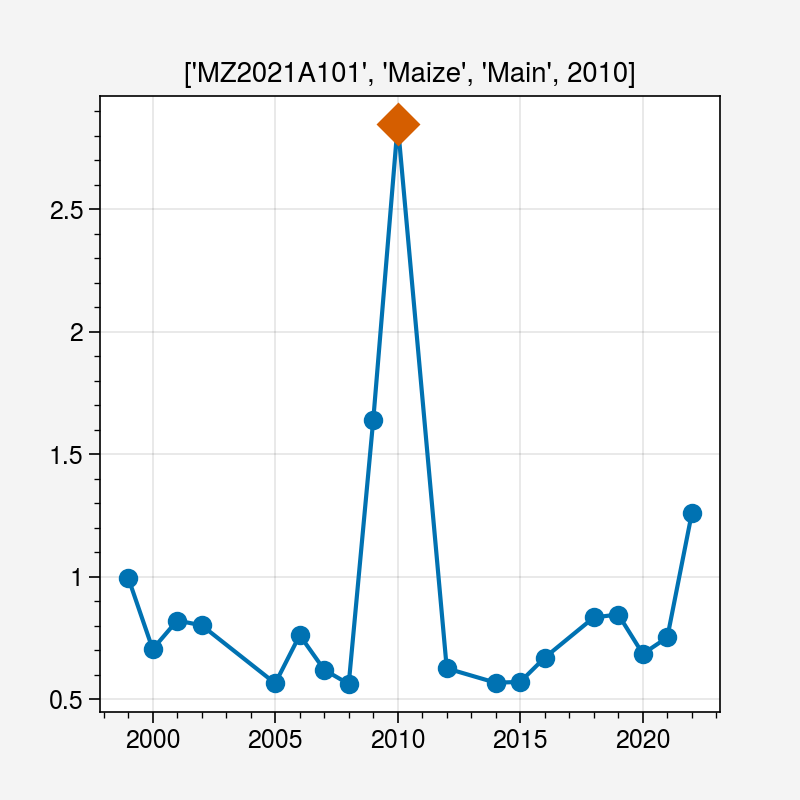

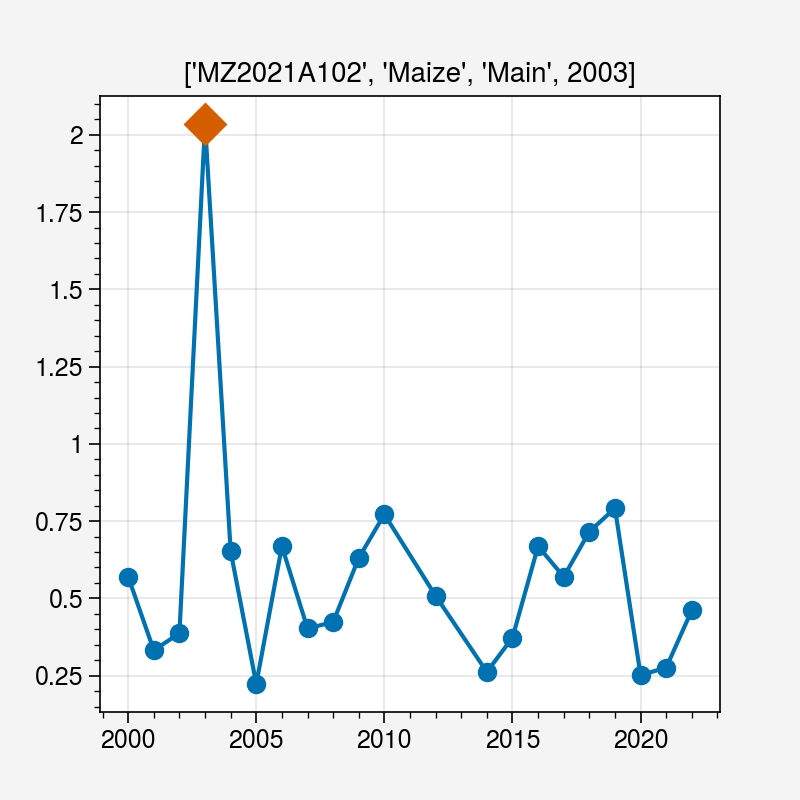

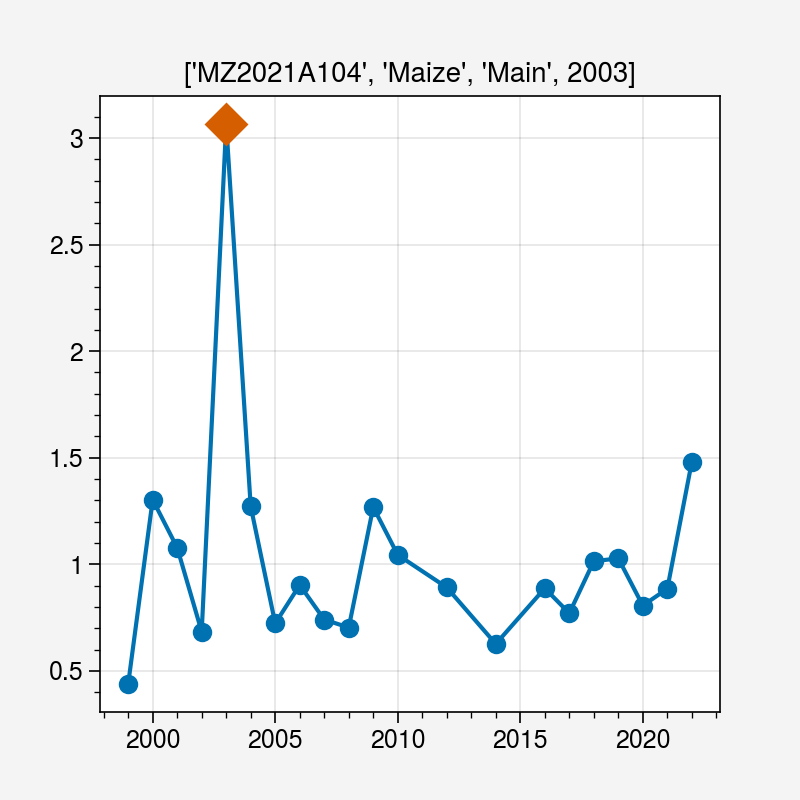

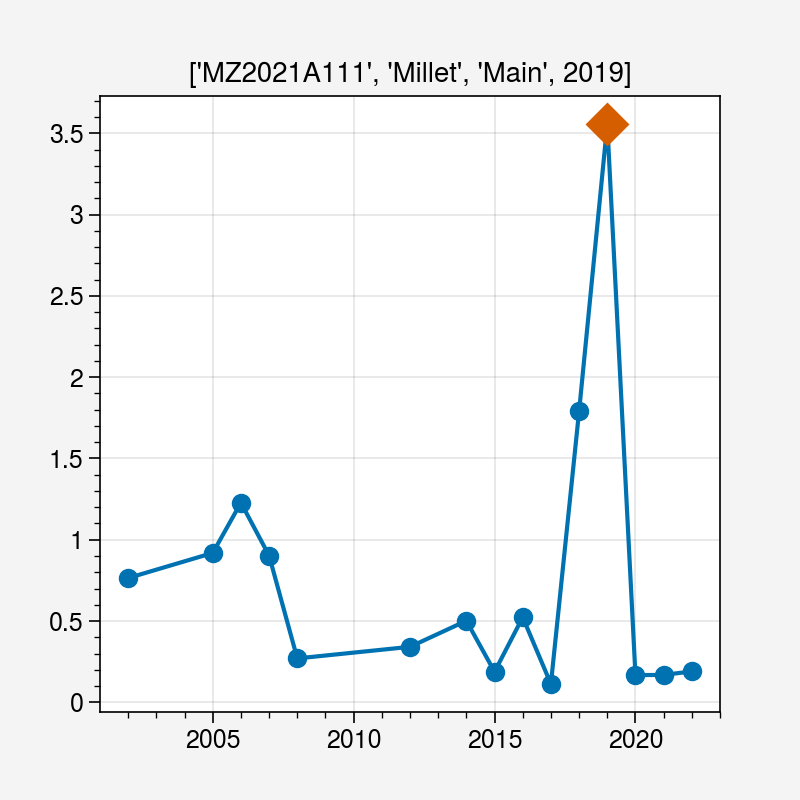

In [8]:
from matplotlib import pyplot as plt

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

outliers = [['MZ2021A101','Maize','Main',2010],
            ['MZ2021A102','Maize','Main',2003],
            ['MZ2021A104','Maize','Main',2003],
            ['MZ2021A111','Millet','Main',2019]
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
    

In [9]:
# Save data
fn_out = '../data/crop/adm_crop_production_MZ.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

../data/crop/adm_crop_production_MZ.csv is saved.


# Visualization of production data

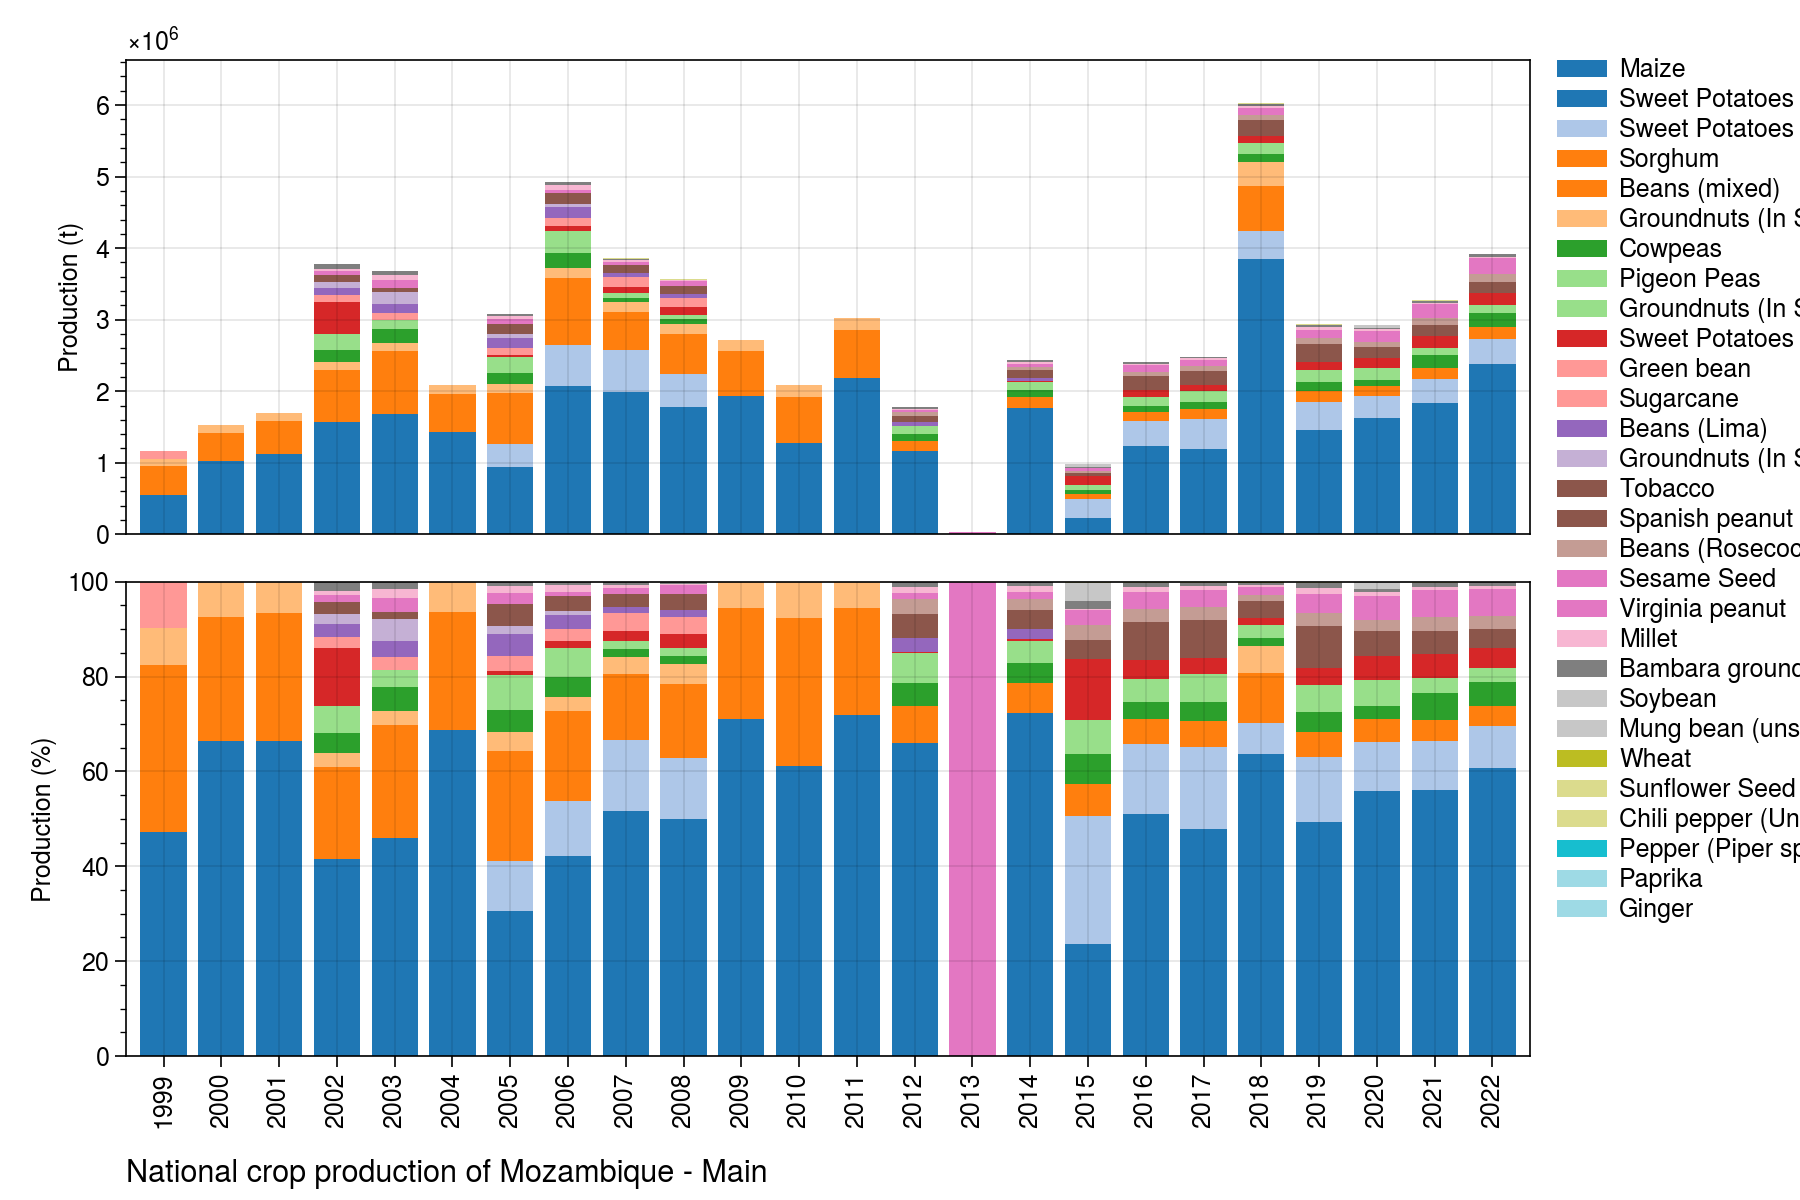

../figures/MZ_bar_natgrainprod_Main.png is saved.


In [10]:
# Bar chart of national crop production
country_iso, country_name = 'MZ', 'Mozambique'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

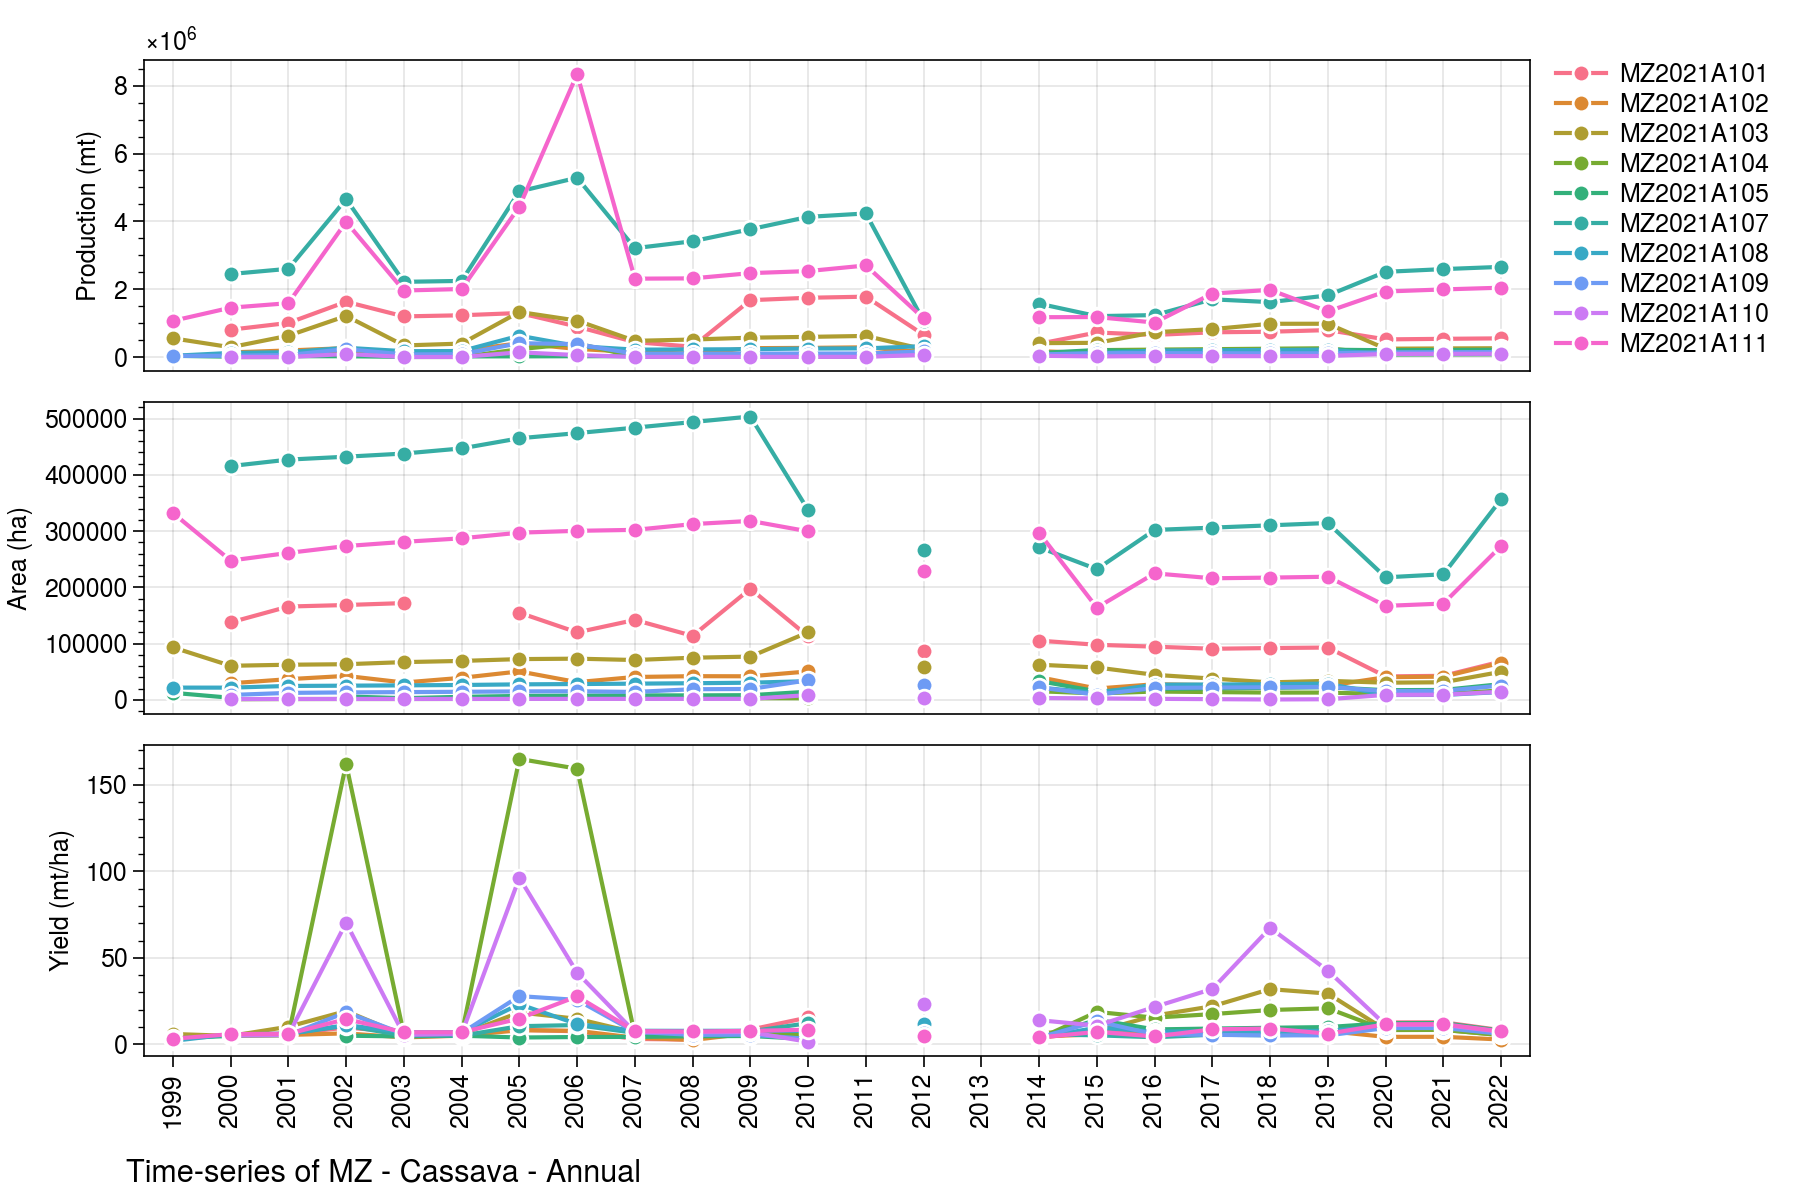

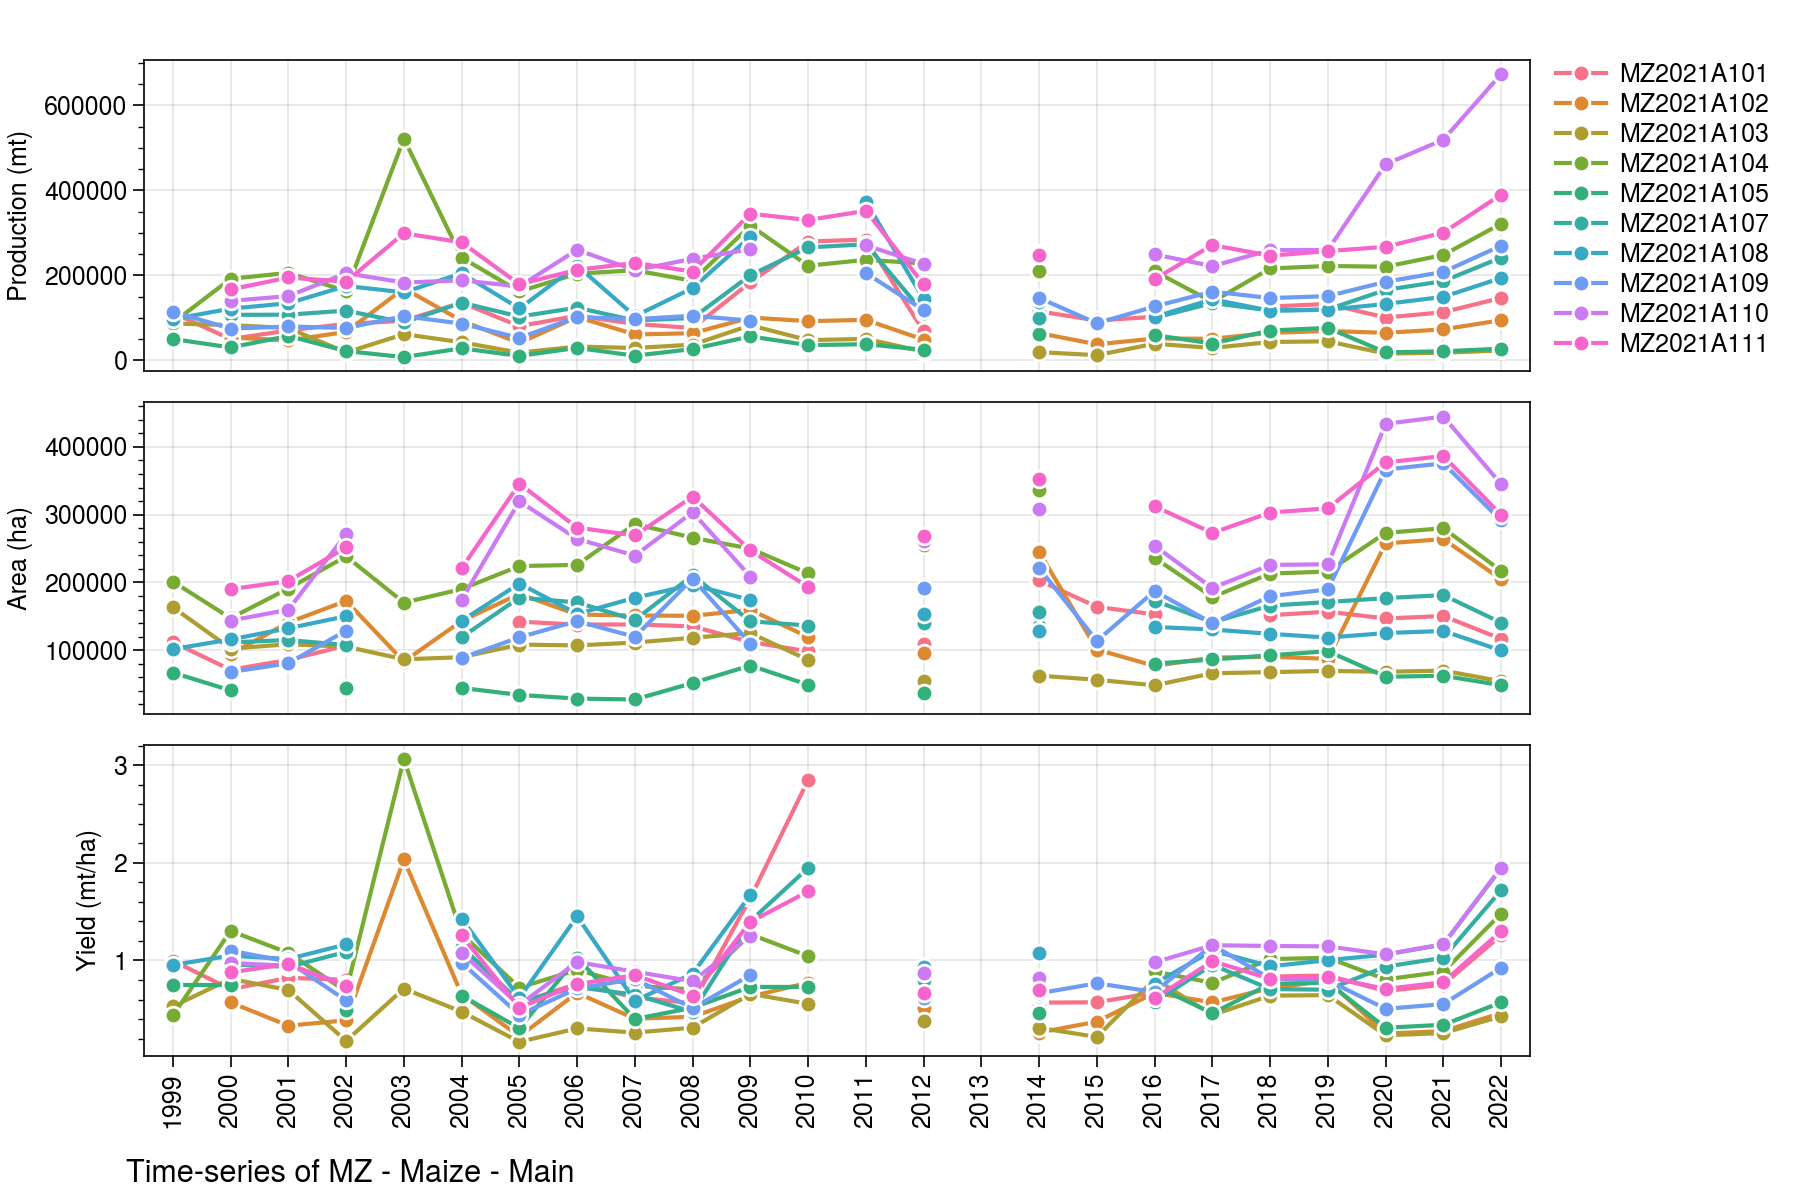

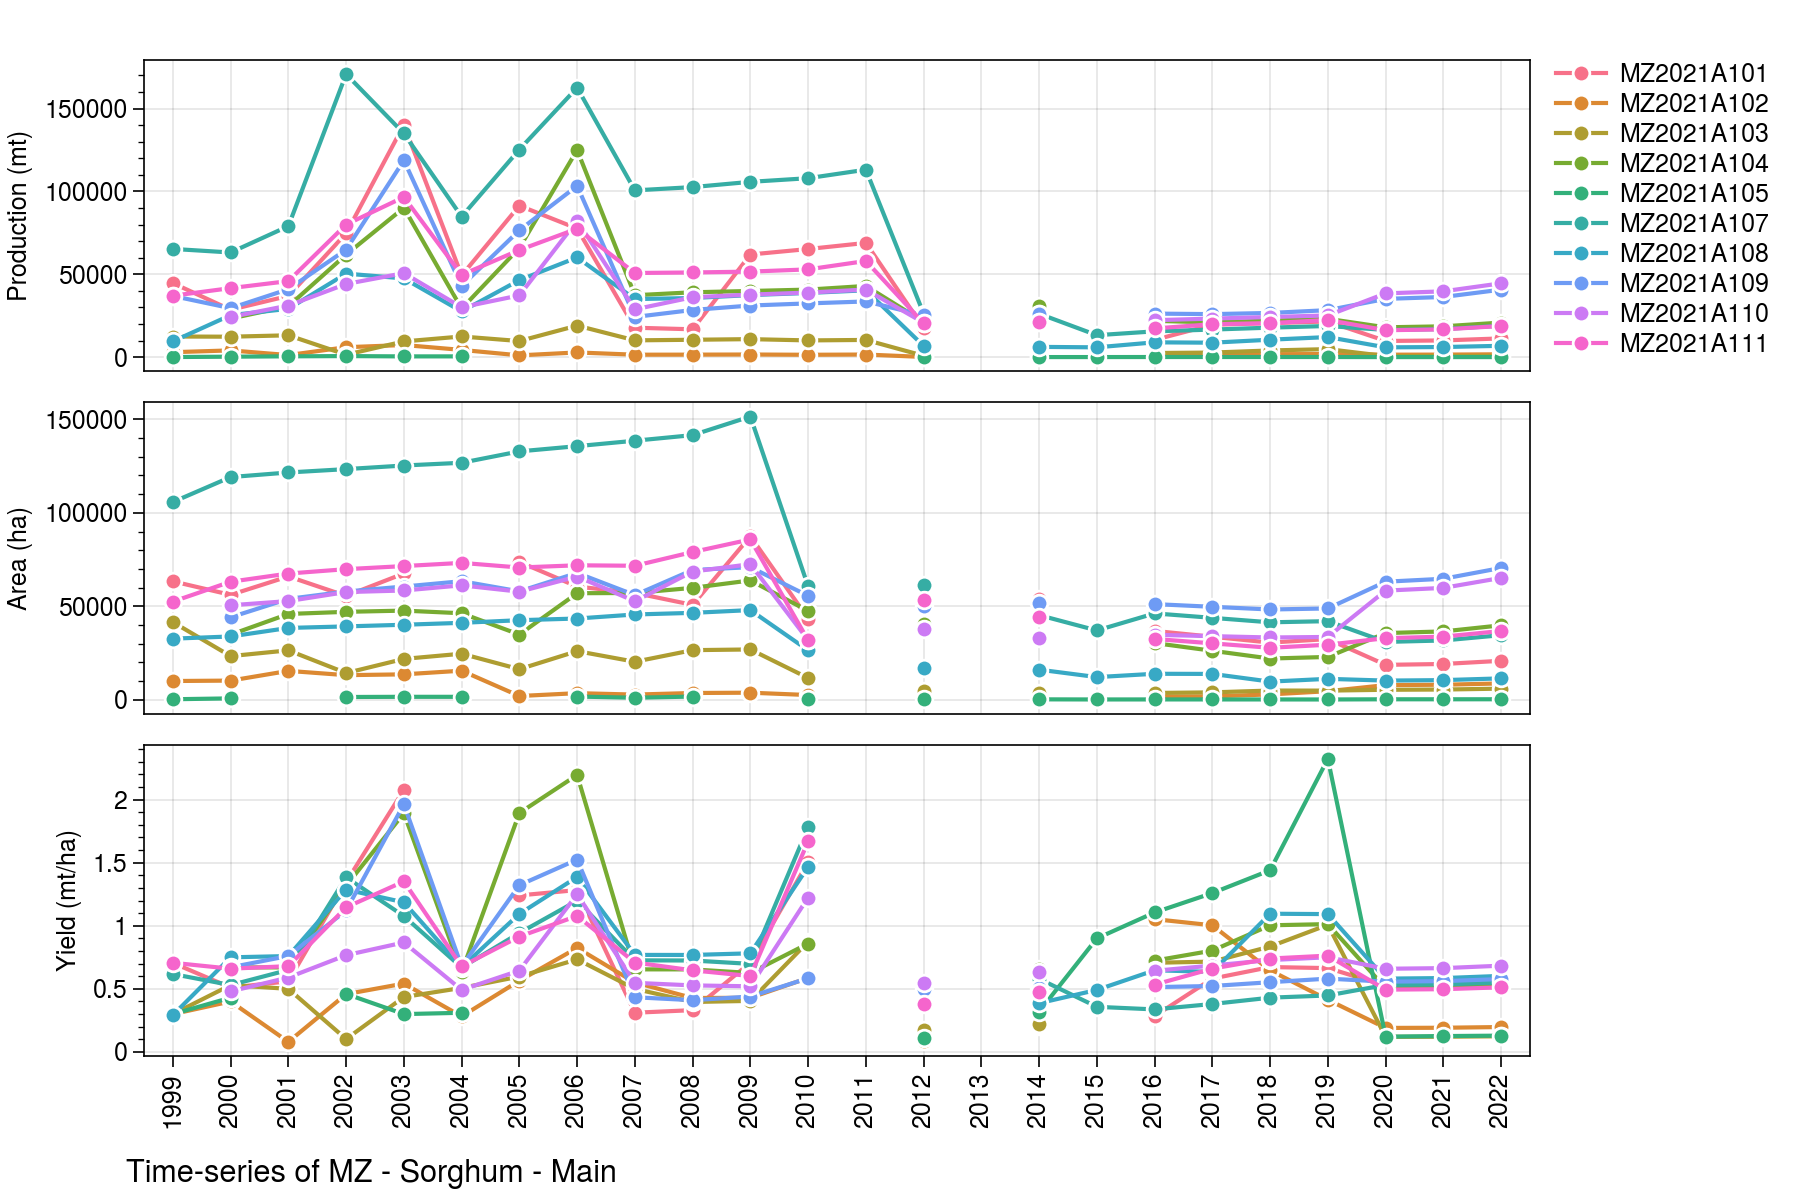

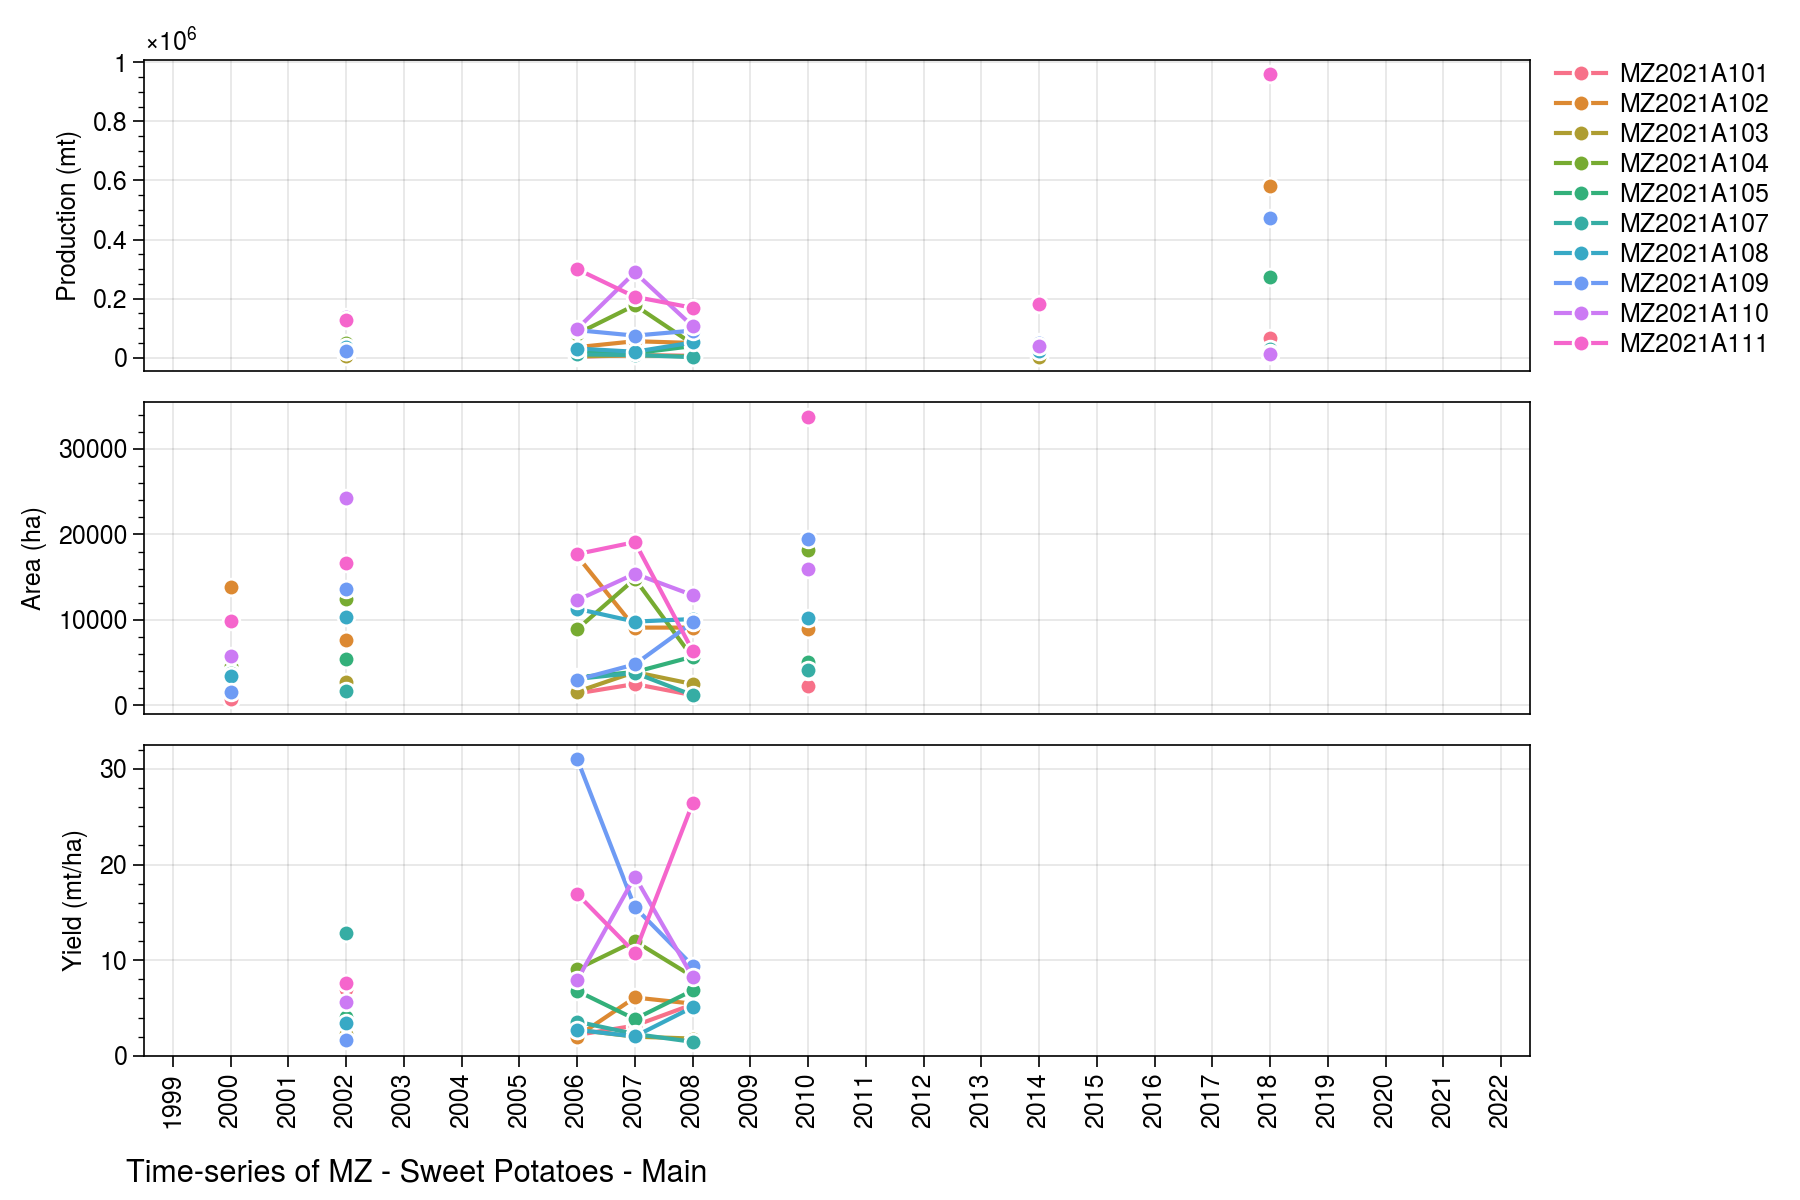

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name ='MZ', 'Mozambique'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava','Annual'],
    ['Maize','Main'],
    ['Sorghum','Main'],
    ['Sweet Potatoes','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)